# Problem 1

I propose the following algorithm: 

1. generate all the spanning trees ($n ^ {n - 2}$ trees for n nodes)
2. take one proportional to the weight
3. add random edge
4. delete random edge in a cycle
5. if the weight differs less then tol -> finish
6. go to 1.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import scipy as sp
import scipy.stats

plt.style.use('ggplot')

%matplotlib inline

def draw_graph(G, show_edges_labels = True):
    plt.figure(figsize = (15, 10))
    plt.axis('off')

    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 4000)
    nx.draw_networkx_edges(G, pos)
    
    if show_edges_labels:
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels = labels)
    
    labels = {}

    for node in G.nodes():
        labels[node] = str(node)
        
    nx.draw_networkx_labels(G, pos, labels = labels)

In [2]:
from itertools import combinations

def generate_spannings(N, weights):
    trees = []
    
    for edges in list(combinations(list(combinations(np.arange(N), 2)), N - 1)):
        g = nx.Graph()

        for v1, v2 in edges:
            g.add_edge(v1, v2, {'weight' : weights[v1, v2]})

        if len(nx.cycle_basis(g)) == 0:
            trees.append(g)
            
    return trees

def compute_sum_cost(graph):
    cost = 0

    for v1, v2 in graph.edges():
        cost += graph.get_edge_data(v1, v2)['weight']
        
    return cost

def compute_mul_cost(graph):
    cost = 1

    for v1, v2 in graph.edges():
        cost *= graph.get_edge_data(v1, v2)['weight']
        
    return cost

average spanning tree cost is: 1.626932681322669


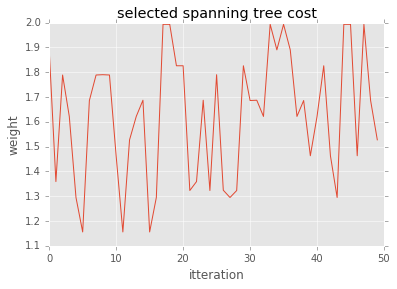

In [10]:
N = 4
itterations = 50
weights = np.random.random(N**2).reshape(N, N)
weights = (weights + weights.T) / 2

def uniform_sampling(N, weights, itterations):
    spanning_trees = generate_spannings(N, weights)
    average_costs = []

    costs = [0] * len(spanning_trees)

    for index, tree in enumerate(spanning_trees):
        costs[index] = compute_sum_cost(tree)
        
    for i in range(itterations):
        distribution = sp.stats.rv_discrete(values=(np.arange(len(costs)), costs / sum(costs)))
        tree_number = distribution.rvs(size = 1)[0] - 1

        tree = spanning_trees[tree_number]
        average_costs.append(compute_sum_cost(tree))

        v1 = np.random.choice(tree.nodes())
        v2 = np.random.choice(tree.nodes())

        while tree.has_edge(v1, v2) or v1 == v2:
            v1 = np.random.choice(tree.nodes())
            v2 = np.random.choice(tree.nodes())

        tree.add_edge(v1, v2, {'weight' : weights[v1, v2]})
        cycle = nx.cycle_basis(tree)[0]
        edges = []

        for v1, v2 in tree.edges():
            if v1 in cycle and v2 in cycle:
                edges.append((v1, v2))

        edge_to_remove = edges[np.random.choice(np.arange(len(edges)))]
        tree.remove_edge(edge_to_remove[0], edge_to_remove[1])

        costs[tree_number] = compute_sum_cost(tree)

        spanning_trees[tree_number] = tree
        
    plt.plot(average_costs)
    plt.title('selected spanning tree weight sum')
    plt.xlabel('itteration')
    plt.ylabel('weight')
    print('average spanning tree cost is: {0}'.format(np.array(average_costs).mean()))
    
uniform_sampling(N, weights, itterations)

average spanning tree cost is: 0.10528377112314713


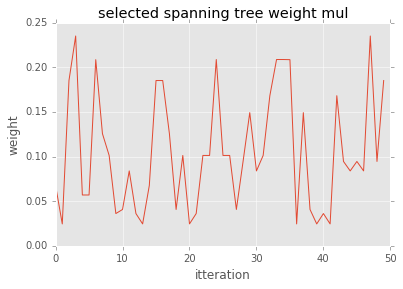

In [15]:
N = 4
itterations = 50
weights = np.random.random(N**2).reshape(N, N)
weights = (weights + weights.T) / 2

def uniform_sampling(N, weights, itterations):
    spanning_trees = generate_spannings(N, weights)
    average_costs = []

    costs = [0] * len(spanning_trees)

    for index, tree in enumerate(spanning_trees):
        costs[index] = compute_mul_cost(tree)
        
    for i in range(itterations):
        distribution = sp.stats.rv_discrete(values=(np.arange(len(costs)), costs / sum(costs)))
        tree_number = distribution.rvs(size = 1)[0] - 1

        tree = spanning_trees[tree_number]
        average_costs.append(compute_mul_cost(tree))

        v1 = np.random.choice(tree.nodes())
        v2 = np.random.choice(tree.nodes())

        while tree.has_edge(v1, v2) or v1 == v2:
            v1 = np.random.choice(tree.nodes())
            v2 = np.random.choice(tree.nodes())

        tree.add_edge(v1, v2, {'weight' : weights[v1, v2]})
        cycle = nx.cycle_basis(tree)[0]
        edges = []

        for v1, v2 in tree.edges():
            if v1 in cycle and v2 in cycle:
                edges.append((v1, v2))

        edge_to_remove = edges[np.random.choice(np.arange(len(edges)))]
        tree.remove_edge(edge_to_remove[0], edge_to_remove[1])

        costs[tree_number] = compute_mul_cost(tree)

        spanning_trees[tree_number] = tree
        
    plt.plot(average_costs)
    plt.title('selected spanning tree weight mul')
    plt.xlabel('itteration')
    plt.ylabel('weight')
    print('average spanning tree cost is: {0}'.format(np.array(average_costs).mean()))
    
uniform_sampling(N, weights, itterations)

# Problem 2

First we want to reconstruct the path with the greates information: 

It is the path between nodes $x_2$ and $x_3$.

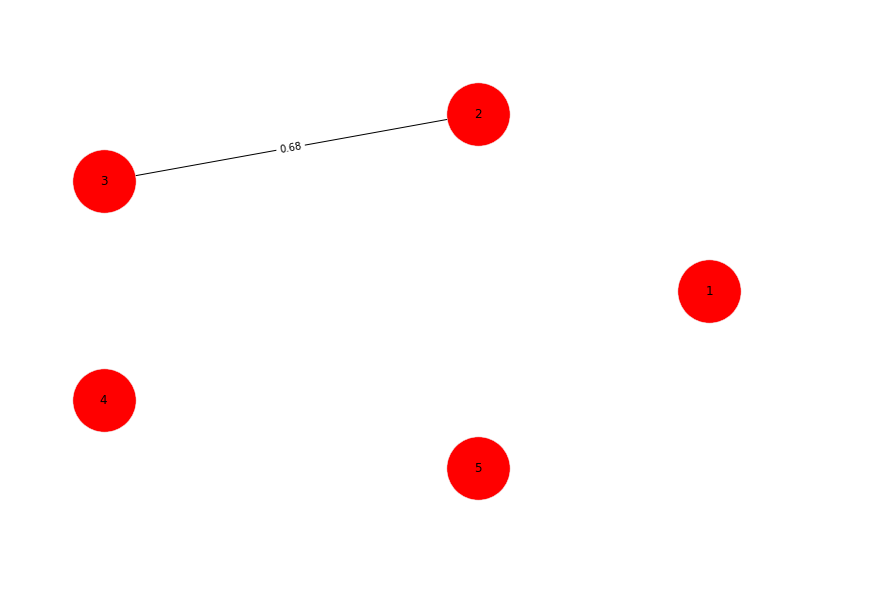

In [2]:
g = nx.Graph()

for i in range(5):
    g.add_node(i + 1)
    
g.add_edge(2, 3, {'weight' : 0.68})

draw_graph(g)

The next path by mutual information is between $x_1$ and $x_5$

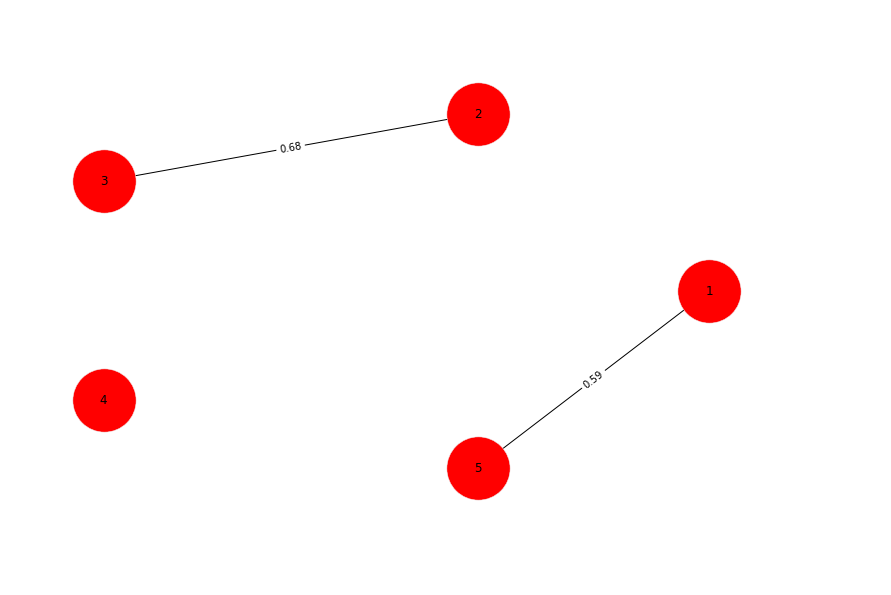

In [3]:
g.add_edge(1, 5, {'weight' : 0.59})

draw_graph(g)

The next one is between $x_1$ and $x_2$.

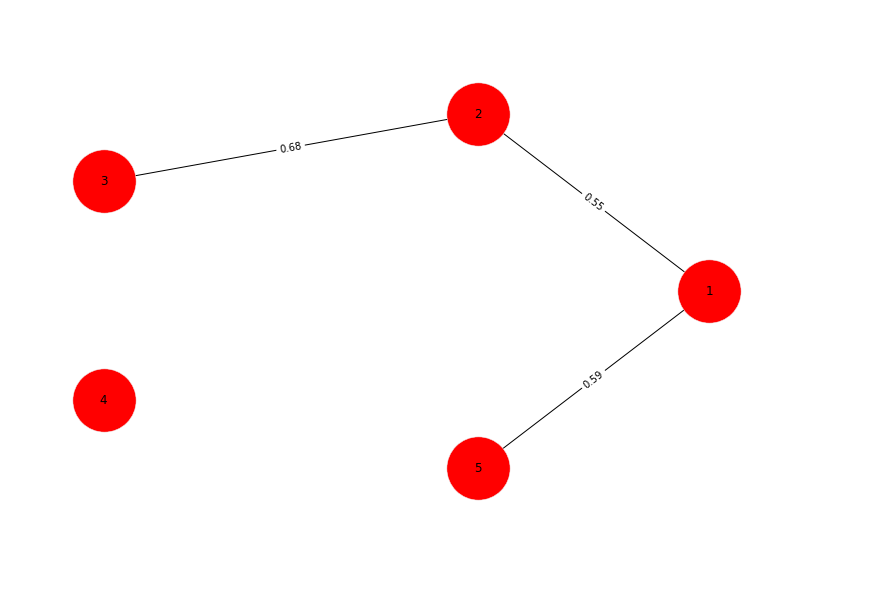

In [4]:
g.add_edge(1, 2, {'weight' : 0.55})

draw_graph(g)

The edge between $x_1$ and $x_3$ adds a loop to the tree thus we ommit it. The same for $x_2$ and $x_5$, $x_3$ and $x_5$. And we have to add just node $x_4$. The maximum information for edge containing $x_4$ is for $x_4$ and $x_1$

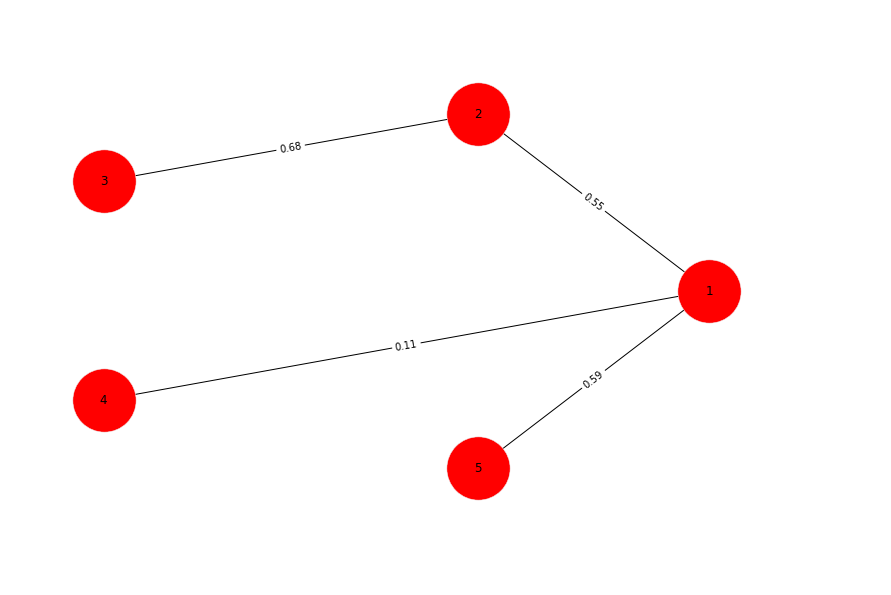

In [5]:
g.add_edge(1, 4, {'weight' : 0.11})

draw_graph(g)

The maximum probable tree has the following view:

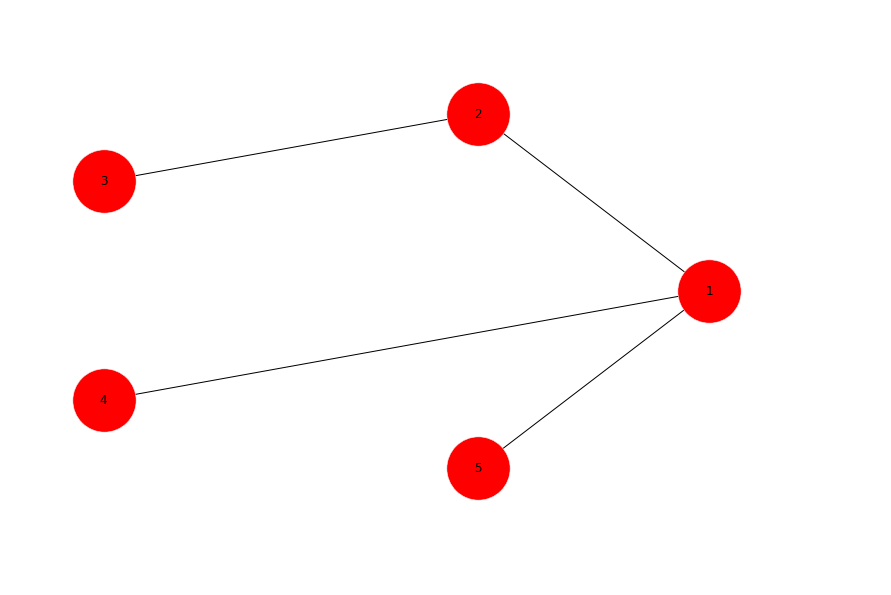

In [7]:
g = nx.Graph()

for i in range(5):
    g.add_node(i + 1)
    
g.add_edge(1, 2)
g.add_edge(1, 4)
g.add_edge(2, 3)
g.add_edge(1, 5)

draw_graph(g)

# Problem 3

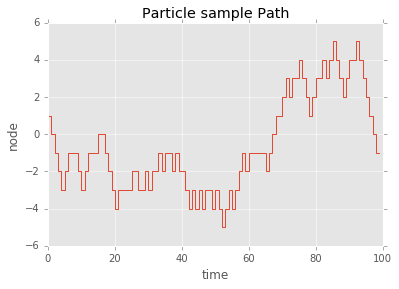

In [17]:
import scipy as sp
import scipy.stats

states = [0]
steps = 100
mu = 0.4
lam = 0.4
left_count = 0
right_count = 0
eps = 1 - mu - lam

jumps = [-1, 0, 1]
distribution = sp.stats.rv_discrete(values=(jumps, [mu, eps, lam]))

assert mu < steps and lam < steps

def next_step(current_state):
    return current_state + distribution.rvs(size = 1)

for i in range(steps):
    states.append(next_step(states[-1]))

plt.title('Particle sample Path')
plt.xlabel('time')
plt.ylabel('node')
plt.step(np.arange(steps), states[:-1])

In [91]:
def p(n, t):
    states = { 0 : { 0 : 1 } }
    
    for i in range(1, t + 1):
        states[i] = {}

        for prev_state, p in states[i - 1].items():
            if prev_state not in states[i]:
                states[i][prev_state] = 0
            if prev_state + 1 not in states[i]:
                states[i][prev_state + 1] = 0
            if prev_state - 1 not in states[i]:
                states[i][prev_state - 1] = 0

            states[i][prev_state] += p * distribution.pmf(0)
            states[i][prev_state - 1] += p * distribution.pmf(-1)
            states[i][prev_state + 1] += p * distribution.pmf(1)
            
    if t == 0 and n == 0:
        return 1
    
    if t == 1:
        if n in [-1, 0, 1]:
            return distribution.pmf(n)
        else:
            return 0

    time_slice = states[t]

    if n not in time_slice:
        return 0
    
    s = 0

    for state, c in time_slice.items():
        s += c
  
    return time_slice[n] / (s - time_slice[n])

In [92]:
p(1, 2)

0.19047619047619044

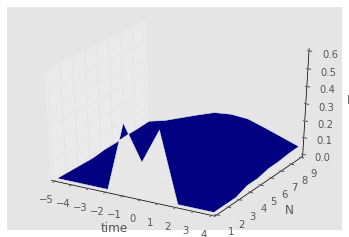

In [100]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Y, X = np.meshgrid(np.arange(1, 10), np.arange(-5, 5, 1))
zs = np.array([p(x,y) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('time')
ax.set_ylabel('N')
ax.set_zlabel('P')

plt.show()

# Problem 4